In [1]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_May__3_18:49:52_PDT_2022
Cuda compilation tools, release 11.7, V11.7.64
Build cuda_11.7.r11.7/compiler.31294372_0


/home/djjin/anaconda3/envs/conda_visual_HPE/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch:  1.13 ; cuda:  cu117
detectron2: 0.6


In [2]:
from detectron2.utils.logger import setup_logger
setup_logger()

import os, sys
home_dir = os.path.abspath(os.getcwd()+"/../")
sys.path.append(home_dir)
home_dir = os.path.abspath(os.getcwd())
sys.path.append(home_dir)
print(home_dir)

from utils.arguments import load_vcoco_opt_command
from utils.distributed import init_distributed

/home/djjin/Mygit/X-Decoder/notebooks


Invalid MIT-MAGIC-COOKIE-1 key

In [3]:
opt, cmdline_args = load_vcoco_opt_command(home_dir)
opt = init_distributed(opt)

In [4]:
from datasets.registration.register_vcoco_dataset import register_all_vcoco
_root = os.getenv("DATASET", "../datasets")
register_all_vcoco(_root)

datasets/ADE20K_2021_17_01/images_detectron2/training
datasets/ADE20K_2021_17_01/images_detectron2/validation


In [5]:
from datasets.build import build_train_dataloader
train_data_loader = [build_train_dataloader(opt)]
dataset_names = opt['DATASETS']['TRAIN']

[07/14 15:57:55 d2.data.common]: Serializing 5400 elements to byte tensors and concatenating them all ...
[07/14 15:57:55 d2.data.common]: Serialized dataset takes 3.62 MiB


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


213 81 601 512
220 457 451 576


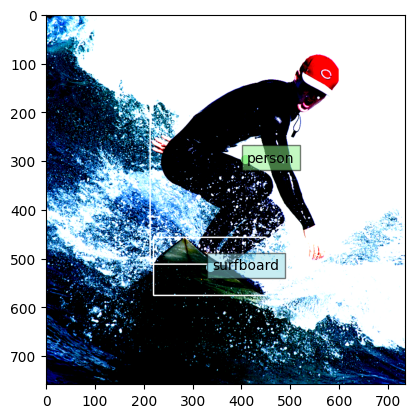

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


513 305 587 329
0 299 58 323
637 301 682 329
373 191 487 350
116 215 195 369
245 184 371 342
573 222 695 372
251 280 270 306
57 281 80 323
113 357 198 378
286 304 346 348
420 306 495 352
556 369 638 383
188 278 208 318
79 306 131 322
219 276 239 306
249 347 513 381


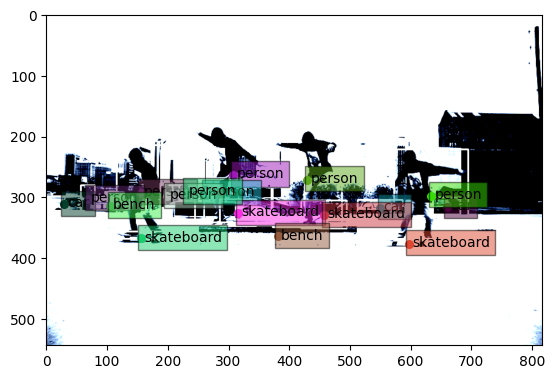

219 164 255 267
306 151 348 260
98 301 182 310


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 312 43 320
377 237 460 247
98 287 267 301
216 264 388 276
311 253 445 266
0 292 43 305
116 182 163 291
59 194 116 301
183 177 222 284
346 135 403 237
499 130 548 223
524 149 559 221
0 326 58 339
496 221 559 229
0 269 344 415


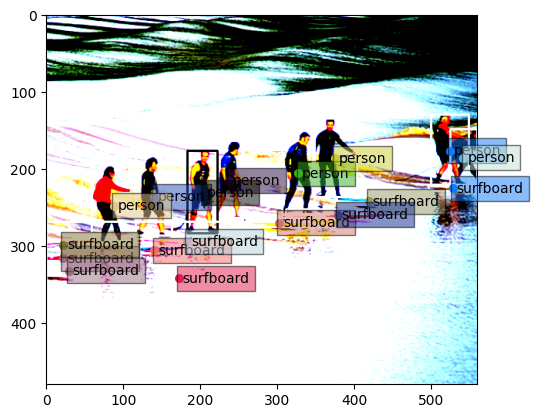

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


527 212 582 419
260 192 366 444
43 199 139 437
0 186 57 431
469 213 537 423
236 241 473 363
526 275 599 343
0 257 84 338
444 252 559 333
110 279 138 339
235 225 292 304
401 297 454 420
408 210 429 238
292 356 318 424


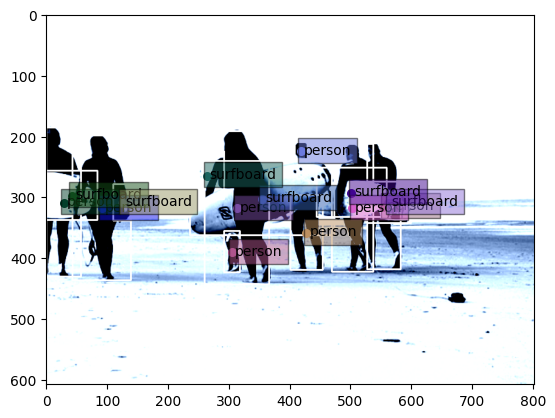

703 178 894 307
174 257 292 291
11 311 74 336
632 242 759 274
919 260 945 285


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


201 307 236 342
819 245 902 483
736 293 813 399
585 254 723 387
173 280 304 401
541 265 580 374
311 288 410 365
553 307 624 383
386 294 437 361
899 262 949 387
806 250 839 303
936 284 981 552
0 277 691 618
868 256 921 390
583 286 608 313
932 6 957 104
59 248 979 544


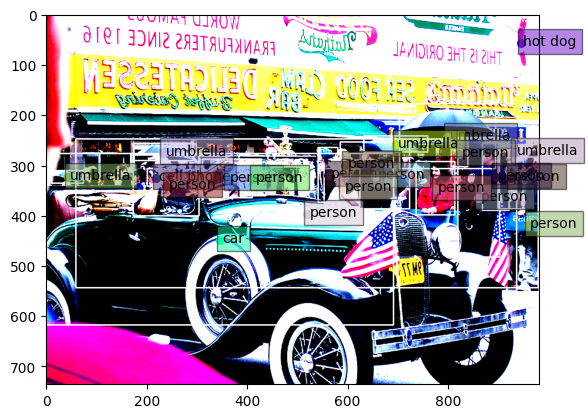

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


461 429 492 459
573 246 662 461
439 249 535 469
390 230 432 315
532 271 601 387
857 225 984 551
218 289 240 310
154 300 183 308


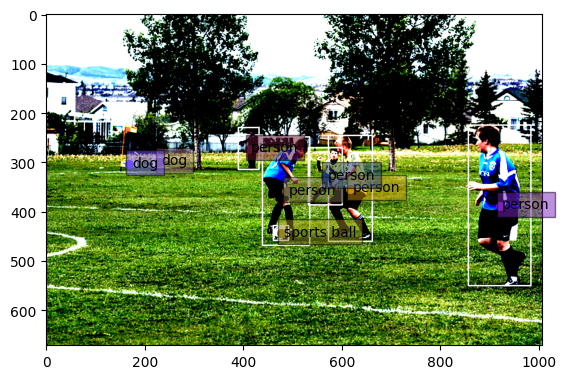

In [6]:
import cv2, random
from datasets.utils.vcoco_utils import valid_obj_ids, get_coco_instance_ID_to_name
from matplotlib import pyplot as plt
def random_color():
    rdn = random.randint(1, 1000)
    b = int(rdn * 997) % 255
    g = int(rdn * 4447) % 255
    r = int(rdn * 6563) % 255
    return b, g, r

for dataloader, dataset_name in zip(train_data_loader, dataset_names):
    with torch.no_grad():
        for idx, batch in enumerate(dataloader):
            if idx > 2:
                break
            for test in batch:
                target_img = test["image"]
                target = test["instances"]
                img = target_img.permute(1, 2, 0).detach().cpu().numpy()
                hh, ww = img.shape[0], img.shape[1]
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

                obj_labels = []
                labels = []
                verb_names = []
                ob_boxes = []
                sub_boxes = []

                obj_boxes = target['boxes']
                for test in range(obj_boxes.shape[0]):
                    cx, cy, w, h = obj_boxes[test]
                    color = random_color()
                    cx, cy, w, h = cx * ww, cy * hh, w * ww, h * hh
                    n_box = list(map(int, [cx - 0.5 * w, cy - 0.5 * h, cx + 0.5 * w, cy + 0.5 * h]))
                    x1, y1, x2, y2 = n_box
                    ob_boxes.append(n_box)
                    
                for idx in target['labels']:
                    label_name = get_coco_instance_ID_to_name(valid_obj_ids[idx])
                    labels.append(label_name)

                for label, box in zip(labels, ob_boxes):
                    color = random_color()
                    x1, y1, x2, y2 = box
                    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

                    x = (x1 + x2) / 2
                    y = (y1 + y2) / 2

                    plt.scatter(x, y, 30, color=[i/255 for i in color])
                    plt.text(
                        x + 5,
                        y + 5,
                        label,
                        fontsize=10,
                        bbox=dict(facecolor=[i/255 for i in color], alpha=0.5),
                        )

                plt.imshow(img)
                plt.show()